# Binary Classification of Tuberculosis disease

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pathlib import Path
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2 
import pandas as pd 
import os 

import warnings
warnings.filterwarnings('ignore')

# 1. Preprocessing

In [2]:
def convert_to_grayscale(image_path, output_dir):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_dir, filename)
    # Save the grayscale image
    cv2.imwrite(output_path, gray_image)

In [3]:
def apply_grayscale(directory, output_dir):
    # Check if the output directory exists, if not, create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Iterate over the files in the directory
    for filename in os.listdir(directory):
        # Check if the file is an image (you can add more file extensions if needed)
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg") :
            image_path = os.path.join(directory, filename)
            convert_to_grayscale(image_path, output_dir)

### Applying grayscale to the dataset

In [4]:
tb_source = "Dataset/Tuberculosis/"
tb_target = "transformed_data/Tuberculosis"

apply_grayscale(tb_source, tb_target)

In [5]:
normal_source = "Dataset/Normal/"
normal_target = "transformed_data/Normal"

apply_grayscale(normal_source, normal_target)

### The following is a function that is going to randomly pick images from the dataset and move them to the inference directory (used in the inferencing step later)

In [6]:
import random 
import os

def inference_images(src_path, target_path):
    for i in range(100) : 
        file = random.choice(os.listdir(src_path))
        capture = cv2.imread(os.path.join(src_path,file))
        image_path = src_path+file
        captured = cv2.imwrite(target_path+file, capture)
        os.remove(image_path)

        print(f"{file} Moved To Inference Directory.") 

In [7]:
inference_tb_source = "transformed_data/Tuberculosis/"
inference_tb_target = "Inference/Tuberculosis/"
if not os.path.exists(inference_tb_target):
    os.makedirs(inference_tb_target)
    
inference_normal_source = "transformed_data/Normal/"
inference_normal_target = "Inference/Normal/"
if not os.path.exists(inference_normal_target):
    os.makedirs(inference_normal_target)

In [8]:
inference_images(inference_normal_source, inference_normal_target)
inference_images(inference_tb_source, inference_tb_target)

Normal (1187).jpg Moved To Inference Directory.
Normal (1763).jpg Moved To Inference Directory.
Normal (3405).jpg Moved To Inference Directory.
Normal (3306).jpg Moved To Inference Directory.
Normal (1914).jpg Moved To Inference Directory.
Normal (882).jpg Moved To Inference Directory.
Normal (2308).jpg Moved To Inference Directory.
Normal (2834).jpg Moved To Inference Directory.
Normal (3148).jpg Moved To Inference Directory.
Normal (1057).jpg Moved To Inference Directory.
Normal (1700).jpg Moved To Inference Directory.
Normal (259).jpg Moved To Inference Directory.
Normal (2711).jpg Moved To Inference Directory.
Normal (102).jpg Moved To Inference Directory.
Normal (2859).jpg Moved To Inference Directory.
Normal (220).jpg Moved To Inference Directory.
Normal (1706).jpg Moved To Inference Directory.
Normal (2029).jpg Moved To Inference Directory.
Normal (446).jpg Moved To Inference Directory.
Normal (1019).jpg Moved To Inference Directory.
Normal (3274).jpg Moved To Inference Director

TB (1898).png Moved To Inference Directory.
TB (1100).png Moved To Inference Directory.
TB (1434).png Moved To Inference Directory.
TB (1750).png Moved To Inference Directory.
TB (2090).png Moved To Inference Directory.
TB (1597).png Moved To Inference Directory.
TB (1166).png Moved To Inference Directory.
TB (1400).png Moved To Inference Directory.


### Creating the training and validation datasets

In [116]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="transformed_data/",
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6800 files belonging to 2 classes.
Using 5440 files for training.


In [117]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory="transformed_data/",
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6800 files belonging to 2 classes.
Using 1360 files for validation.


In [118]:
class_names = train_ds.class_names
print(class_names)

['Normal', 'Tuberculosis']


# 2. Exploratory Data Analysis

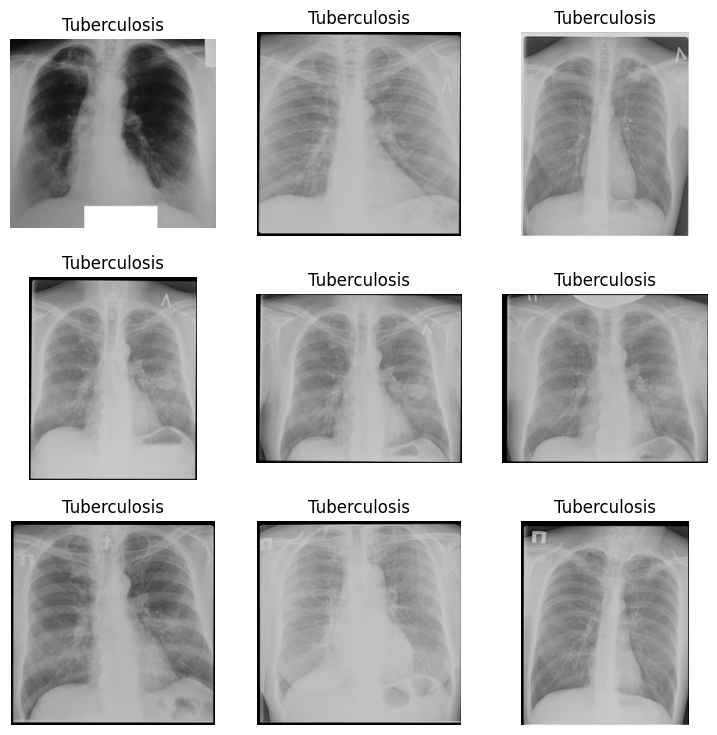

In [54]:
tb_dir = "transformed_data/Tuberculosis/*.*"
# to loop through all images in the directory and read it 
images = [cv2.imread(image) for image in glob(tb_dir)]
rows = 3
cols = 3
# plotting the images
fig = plt.figure(figsize=(9,9))
for j in range(0, rows*cols) : 
    fig.add_subplot(rows, cols, j+1)
    plt.axis("off")
    plt.title('Tuberculosis')
    plt.imshow(images[j])

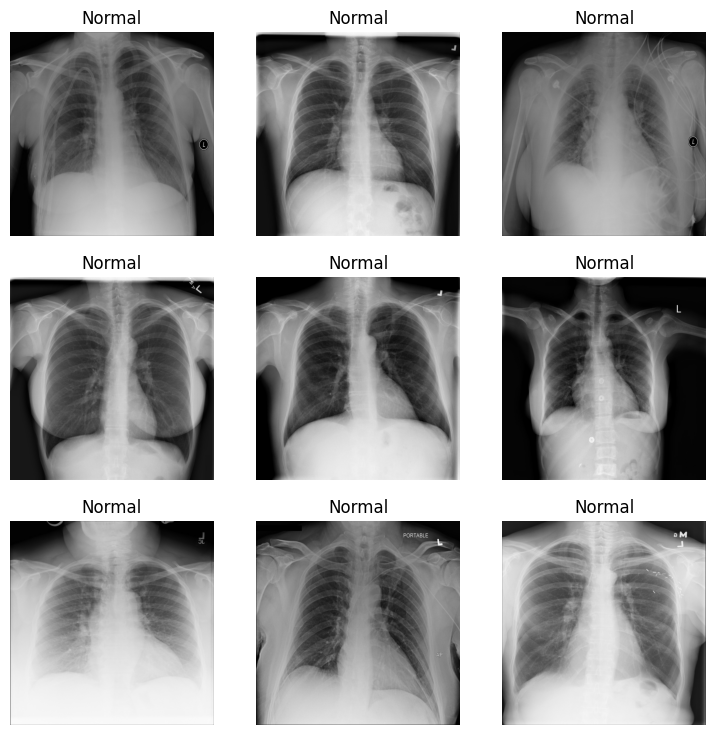

In [55]:
Normal_dir = "transformed_data/Normal/*.*"
# to loop through all images in the directory and read it 
images = [cv2.imread(image) for image in glob(Normal_dir)]
rows = 3
cols = 3
# plotting the images
fig = plt.figure(figsize=(9,9))
for j in range(0, rows*cols) : 
    fig.add_subplot(rows, cols, j+1)
    plt.axis("off")
    plt.title('Normal')
    plt.imshow(images[j])

# 3. Model Building

In [119]:
num_classes = len(class_names)
tf.random.set_seed(42)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [120]:
model.compile(optimizer='adam',loss='categorical_crossentropy' , metrics=['accuracy'])

In [121]:
# Stops the training if the validation accuracy doesn't improve for 10 consecutive epochs 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
# Reduce the learning rate when the validation accuracy stagnates for 5 consecutive epochs 
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.5, 
                              patience = 5, 
                              min_delta = 0.001,
                              mode='auto',verbose=1)

# 4. Model Training

In [122]:
epochs=50
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[reduce_lr, callback]
)

Epoch 1/50
170/170 [==============================] - 13s 50ms/step - loss: 0.4304 - accuracy: 0.7899 - val_loss: 0.2850 - val_accuracy: 0.8868
Epoch 2/50
170/170 [==============================] - 9s 49ms/step - loss: 0.1655 - accuracy: 0.9369 - val_loss: 0.1179 - val_accuracy: 0.9574
Epoch 3/50
170/170 [==============================] - 9s 51ms/step - loss: 0.0919 - accuracy: 0.9676 - val_loss: 0.1065 - val_accuracy: 0.9654
Epoch 4/50
170/170 [==============================] - 9s 49ms/step - loss: 0.0692 - accuracy: 0.9756 - val_loss: 0.0561 - val_accuracy: 0.9765
Epoch 5/50
170/170 [==============================] - 9s 50ms/step - loss: 0.0511 - accuracy: 0.9812 - val_loss: 0.0603 - val_accuracy: 0.9787
Epoch 6/50
170/170 [==============================] - 8s 49ms/step - loss: 0.0544 - accuracy: 0.9812 - val_loss: 0.0521 - val_accuracy: 0.9846
Epoch 7/50
170/170 [==============================] - 9s 50ms/step - loss: 0.0349 - accuracy: 0.9875 - val_loss: 0.0685 - val_accuracy: 0.978

# 5. Model Evaluation

### Accuracy and Loss Plots

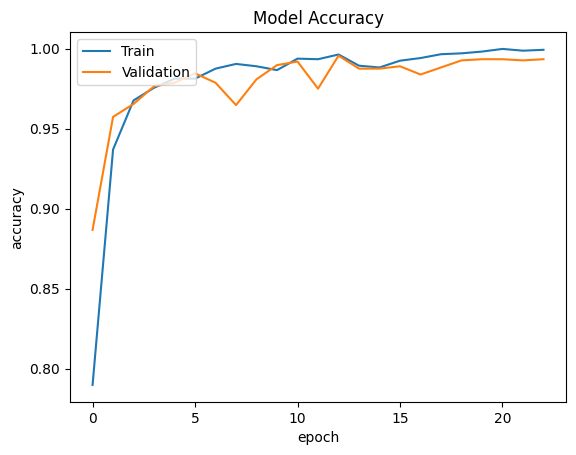

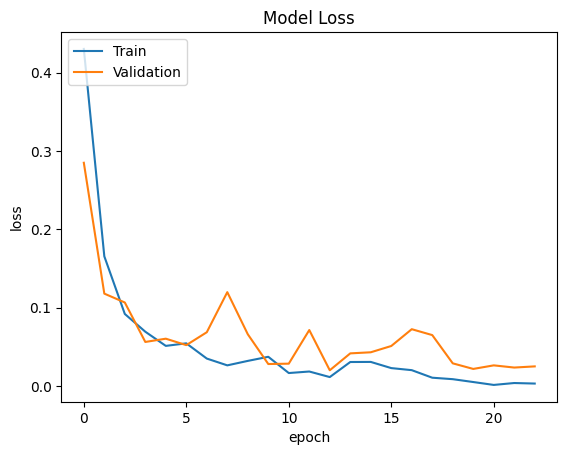

In [123]:
# Plot the history for accuracy 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot the history for loss 
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [124]:
# EVALUATE TRAINING ACCURACY
results = model.evaluate(train_ds)

170/170 [==============================] - 5s 27ms/step - loss: 3.0402e-04 - accuracy: 1.0000


In [125]:
# EVALUATE VALIDATION ACCURACY
results = model.evaluate(val_ds)

43/43 [==============================] - 1s 26ms/step - loss: 0.0249 - accuracy: 0.9934


### Inference Stage

In [126]:
import os
from os import listdir
from cv2 import imread

# THIS FUNCTION TAKES AN IMAGE AS AN INPUT AND THEN RUN IT THROUGH THE MODEL 
def predict(img_path):  
    img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = predictions[0]
    res = "   This image most likely belongs to {} with a {:.2f} percent confidence."\
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    print(res)

def inference(inference_dic) : 
    for images in os.listdir(inference_dic):
        if (images.endswith(".png")) or images.endswith(".jpeg") or images.endswith(".jpg") :
            img = imread(images)
            img_path = (inference_dic+images)
            predict(img_path)

inference_tb = "Inference/Tuberculosis/"
print("TUBERCULOSIS PREDICTIONS OF UNSEEND DATA:")
inference(inference_tb)

inference_normal = "Inference/Normal/"
print("NORMAL PREDICTIONS OF UNSEEND DATA:")
inference(inference_normal)

TUBERCULOSIS PREDICTIONS OF UNSEEND DATA:
   This image most likely belongs to Tuberculosis with a 100.00 percent confidence.
   This image most likely belongs to Tuberculosis with a 100.00 percent confidence.
   This image most likely belongs to Tuberculosis with a 100.00 percent confidence.
   This image most likely belongs to Tuberculosis with a 100.00 percent confidence.
   This image most likely belongs to Tuberculosis with a 100.00 percent confidence.
   This image most likely belongs to Tuberculosis with a 100.00 percent confidence.
   This image most likely belongs to Tuberculosis with a 100.00 percent confidence.
   This image most likely belongs to Tuberculosis with a 100.00 percent confidence.
   This image most likely belongs to Tuberculosis with a 100.00 percent confidence.
   This image most likely belongs to Tuberculosis with a 100.00 percent confidence.
   This image most likely belongs to Tuberculosis with a 100.00 percent confidence.
   This image most likely belongs 

   This image most likely belongs to Normal with a 100.00 percent confidence.
   This image most likely belongs to Normal with a 100.00 percent confidence.
   This image most likely belongs to Normal with a 100.00 percent confidence.
   This image most likely belongs to Normal with a 100.00 percent confidence.
   This image most likely belongs to Normal with a 100.00 percent confidence.
   This image most likely belongs to Normal with a 100.00 percent confidence.
   This image most likely belongs to Normal with a 98.30 percent confidence.
   This image most likely belongs to Normal with a 100.00 percent confidence.
   This image most likely belongs to Normal with a 100.00 percent confidence.
   This image most likely belongs to Normal with a 100.00 percent confidence.
   This image most likely belongs to Normal with a 100.00 percent confidence.
   This image most likely belongs to Normal with a 100.00 percent confidence.
   This image most likely belongs to Normal with a 100.00 percent

### Classification Report and Confusion Matrix

In [127]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in val_ds:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

In [128]:
print(classification_report(true_classes, prediction_classes, target_names=class_names, digits=4))

              precision    recall  f1-score   support

      Normal     0.9912    0.9956    0.9934       677
Tuberculosis     0.9956    0.9912    0.9934       683

    accuracy                         0.9934      1360
   macro avg     0.9934    0.9934    0.9934      1360
weighted avg     0.9934    0.9934    0.9934      1360



In [129]:
cm = confusion_matrix(true_classes, prediction_classes)
print(cm)

[[674   3]
 [  6 677]]


In [130]:
tp = 674
tn = 677
fp = 6 
fn = 3

sensitivity = (tp / (tp+fn)) * 100
specificity = (tn / (tn+fp)) * 100

print(f'Sensitivity: %.2f' % sensitivity,'%')
print(f'Specificity: %.2f' % specificity,'%')

Sensitivity: 99.56 %
Specificity: 99.12 %


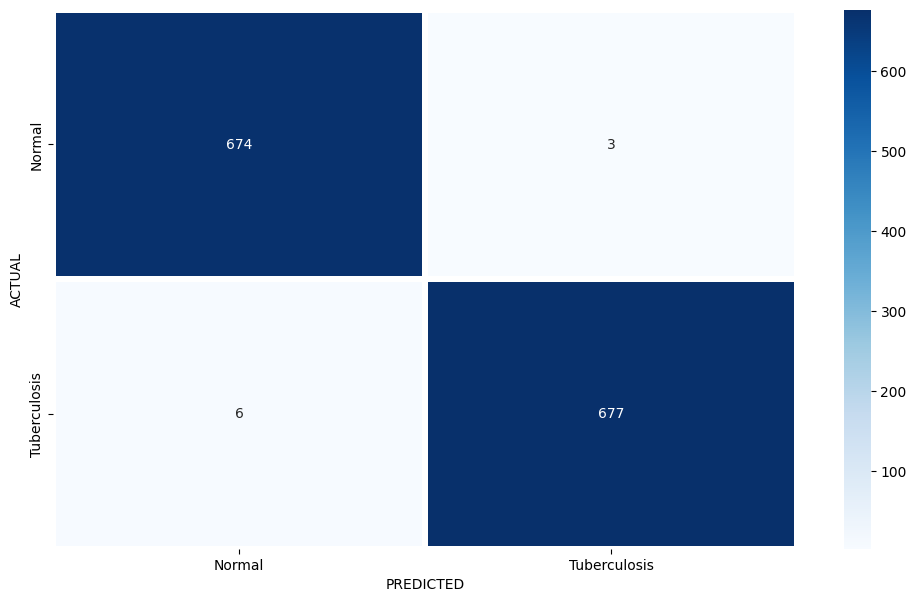

In [131]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
cm = confusion_matrix(true_classes, prediction_classes)

sns.heatmap(cm,cmap="Blues", annot=True,xticklabels=class_names, yticklabels=class_names ,linewidths=3 ,fmt='g')
plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")
plt.show()

## Saving Model and history

In [132]:
model.save("TB_Model.h5")

In [133]:
model = keras.models.load_model("TB_Model.h5")

In [134]:
import pickle
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

In [135]:
import pickle
with open('trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)